In [1]:
import pandas as pd
from wordcloud import WordCloud
import seaborn as sns
import re
import string
from collections import Counter, defaultdict
import numpy as np
import shap

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, f1_score, ConfusionMatrixDisplay
from sklearn.utils import resample
from sklearn.multiclass import OneVsRestClassifier

import plotly.express as px
from plotly.subplots import make_subplots
import plotly.graph_objects as go
from plotly.offline import plot

import matplotlib.gridspec as gridspec
from matplotlib.ticker import MaxNLocator
import matplotlib.patches as mpatches
import matplotlib.pyplot as plt

from nltk.sentiment import SentimentIntensityAnalyzer
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.tokenize import TweetTokenizer
stopWords_nltk = set(stopwords.words('english'))

import warnings
warnings.filterwarnings("ignore")

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/jakubmiksa/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [2]:
import re
from typing import Union, List

class CleanText():
    """ clearing text except digits () . , word character """ 

    def __init__(self, clean_pattern = r"[^A-Za-z0-9\s\r?\n|\r]"):
        self.clean_pattern =clean_pattern

    def __call__(self, text: Union[str, list]) -> List[List[str]]:

        if isinstance(text, str):
            docs = [[text]]

        if isinstance(text, list):
            docs = text

        text = [[re.sub(self.clean_pattern, " ", sent) for sent in sents] for sents in docs]

        return text

def tokenize(text):
    """ basic tokenize method with word character, non word character and digits """
    text = re.sub(r" +", " ", str(text))
    text = re.split(r"(\d+|[^A-Za-z\s\r?\n|\r]+|\W)", text)
    text = list(filter(lambda x: x != '' and x != ' ', text))
    sent_tokenized = text#' '.join(text)
    return sent_tokenized

regex = re.compile('[%s]' % re.escape(string.punctuation))

def remove_punct(text):
    text = regex.sub(" ", text)
    return text

def label_2_int(x):
    if x['Positive'] == 1:
        return 2
    if x['Neutral'] == 1:
        return 1
    if x['Negative'] == 1:
        return 0

def label_2_name(x):
    if x['Positive'] == 1:
        return 'Positive'
    if x['Neutral'] == 1:
        return 'Neutral'
    if x['Negative'] == 1:
        return 'Negative'

clean = CleanText()

In [3]:
df = pd.read_excel('sentences_with_sentiment.xlsx')

In [4]:
df.head()

,ID,Sentence,Positive,Negative,Neutral
0,1,The results in 2nd line treatment show an ORR ...,1,0,0
1,2,The long duration of response and high durable...,1,0,0
2,3,The median OS time in the updated results exce...,0,0,1
3,4,"Therefore, the clinical benefit in 2nd line tr...",1,0,0
4,5,"The data provided in 1st line, although prelim...",1,0,0


In [5]:
df['label'] = df.apply(label_2_int, axis=1)
df['label_name'] = df.apply(label_2_name, axis=1)

In [6]:
df['label'].value_counts()

2    160
1     70
0     36
Name: label, dtype: int64

In [7]:
fig = px.histogram(df,
             x = 'label',
             title = 'Histogram of Sentiments',
             template = 'ggplot2',
             color = 'label',
             color_discrete_sequence= px.colors.sequential.Blues_r,
             opacity = 0.8,
             height = 525,
             width = 835,
            )

fig.update_yaxes(title='Count')
fig.show()

In [8]:
df_duplicates = df.groupby('Sentence').agg({'ID': 'count', 'Positive': 'sum', 'Negative': 'sum', 'Neutral': 'sum'}).reset_index()
df_duplicates = df_duplicates.loc[df_duplicates.ID > 1, :]
(df_duplicates.ID-1).sum()

30

In [9]:
df = df.drop_duplicates(subset=['Sentence'])

In [10]:
with pd.option_context('display.max_colwidth', None):
    display(df.loc[:3]['Sentence'])

0                                         The results in 2nd line treatment show an ORR of 33% with some patients having durable responses resulting in an apparent PFS plateau
1    The long duration of response and high durable response rate observed after 6-month minimum follow-up is further substantiated by the 12-months minimum follow-up analysis
2                                                                                                                     The median OS time in the updated results exceeded 1 year
3             Therefore, the clinical benefit in 2nd line treatment is considered clinically meaningful and the magnitude of the effect is significant compared to chemotherapy
Name: Sentence, dtype: object

In [11]:
df['label'].value_counts()

2    140
1     64
0     32
Name: label, dtype: int64

In [12]:
df["Sentence"] = df["Sentence"].apply(lambda x: remove_punct(clean(x.lower())[0][0]))

In [13]:
df['word_count'] = df["Sentence"].apply(lambda x: len(str(x).split(" ")))
df['char_count'] = df["Sentence"].apply(lambda x: sum(len(word) for word in str(x).split(" ")))
df['avg_word_length'] = df['char_count'] / df['word_count']

In [14]:
df.reset_index(drop=True,inplace=True)
del df['ID']

In [15]:
# nltk.download('vader_lexicon')

vader_features = pd.DataFrame()
sia = SentimentIntensityAnalyzer()

for sentence in df.Sentence:
    vader_features = vader_features.append(sia.polarity_scores(sentence), ignore_index=True)
    
#rename columns
vader_features.rename(columns={'neg':'vader_neg', 'neu':'vader_neu', 'pos':'vader_pos', 'compound':'vader_compound'}, inplace=True)

df = pd.concat([df, vader_features], axis=1)

In [16]:
train, test = train_test_split(df, test_size=0.2, train_size=0.8, stratify=df['label'], random_state=42)

In [17]:
vectorizer = TfidfVectorizer(tokenizer=tokenize)
full_text = list(train['Sentence'].values) + list(test['Sentence'].values)
vectorizer.fit(full_text)
train_vectorized = vectorizer.transform(train['Sentence'])
test_vectorized = vectorizer.transform(test['Sentence'])
y_train = train['label']
y_test = test['label']

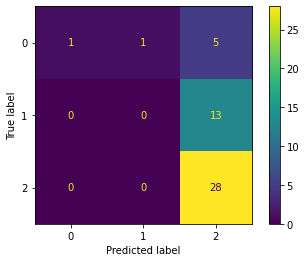

In [18]:
lr = LogisticRegression()
lr.fit(train_vectorized,y_train)
predictions = lr.predict(test_vectorized)
cf_matrix = confusion_matrix(y_test, predictions)
disp = ConfusionMatrixDisplay(cf_matrix)
disp.plot()
plt.show()

In [19]:
print(classification_report(predictions,y_test, labels=[0,1,2]))

              precision    recall  f1-score   support

           0       0.14      1.00      0.25         1
           1       0.00      0.00      0.00         1
           2       1.00      0.61      0.76        46

    accuracy                           0.60        48
   macro avg       0.38      0.54      0.34        48
weighted avg       0.96      0.60      0.73        48



In [20]:
vectorizer = CountVectorizer(token_pattern=r'\b\w+\b')
full_text = list(train['Sentence'].values) + list(test['Sentence'].values)
vectorizer.fit(full_text)
train_vectorized = vectorizer.transform(train['Sentence']).toarray()
test_vectorized = vectorizer.transform(test['Sentence']).toarray()
y_train = train['label']
y_test = test['label']


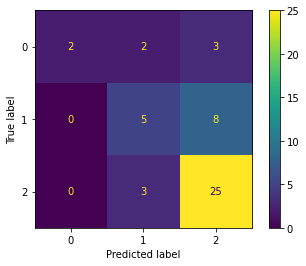

In [21]:
lr = LogisticRegression()
lr.fit(train_vectorized,y_train)
predictions = lr.predict(test_vectorized)
cf_matrix = confusion_matrix(y_test, predictions)
disp = ConfusionMatrixDisplay(cf_matrix)
disp.plot()
plt.show()

In [22]:
print(classification_report(predictions,y_test, labels=[0,1,2]))

              precision    recall  f1-score   support

           0       0.29      1.00      0.44         2
           1       0.38      0.50      0.43        10
           2       0.89      0.69      0.78        36

    accuracy                           0.67        48
   macro avg       0.52      0.73      0.55        48
weighted avg       0.76      0.67      0.70        48



In [23]:
scores = cross_val_score(lr, train_vectorized, y_train, scoring='f1_weighted', n_jobs=-1, cv=5)
print('Cross-validation mean f1_score {0:.2f}%, std {1:.2f}.'.format(np.mean(scores), np.std(scores)))

Cross-validation mean f1_score 0.61%, std 0.03.


In [24]:
vectorizer = tfidfvectorizer = TfidfVectorizer(token_pattern=r'\b\w+\b')
full_text = list(train['Sentence'].values) + list(test['Sentence'].values)
vectorizer.fit(full_text)
train_vectorized = vectorizer.transform(train['Sentence']).toarray()
test_vectorized = vectorizer.transform(test['Sentence']).toarray()


vectorizer = CountVectorizer(token_pattern=r'\b\w+\b')
full_text = list(train['Sentence'].values) + list(test['Sentence'].values)
vectorizer.fit(full_text)
train_vectorized_2 = vectorizer.transform(train['Sentence']).toarray()
test_vectorized_2 = vectorizer.transform(test['Sentence']).toarray()


train_matrix = np.hstack((train_vectorized, train_vectorized_2))
test_matrix = np.hstack((test_vectorized, test_vectorized_2))
y_train = train['label']
y_test = test['label']

In [25]:
train_matrix.shape

(188, 2726)

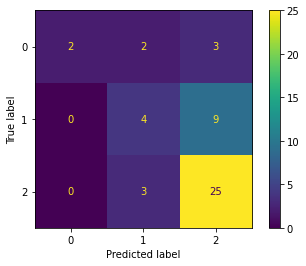

              precision    recall  f1-score   support

           0       0.29      1.00      0.44         2
           1       0.31      0.44      0.36         9
           2       0.89      0.68      0.77        37

    accuracy                           0.65        48
   macro avg       0.50      0.71      0.53        48
weighted avg       0.76      0.65      0.68        48



In [26]:
lr = LogisticRegression()
lr.fit(train_matrix,y_train)
predictions = lr.predict(test_matrix)
cf_matrix = confusion_matrix(y_test, predictions)
disp = ConfusionMatrixDisplay(cf_matrix)
disp.plot()
plt.show()
print(classification_report(predictions,y_test, labels=[0,1,2]))

In [27]:
scores = cross_val_score(lr, train_matrix, y_train, scoring='f1_weighted', n_jobs=-1, cv=5)
print('Cross-validation mean f1_score {0:.2f}%, std {1:.2f}.'.format(np.mean(scores), np.std(scores)))

Cross-validation mean f1_score 0.61%, std 0.02.


In [28]:
train_matrix = np.hstack([train[['vader_neg','vader_neu','vader_pos','vader_compound']].to_numpy(),train_vectorized_2])
test_matrix = np.hstack([test[['vader_neg','vader_neu','vader_pos','vader_compound']].to_numpy(),test_vectorized_2])

In [29]:
train_matrix

array([[0.   , 0.867, 0.133, ..., 0.   , 1.   , 0.   ],
       [0.07 , 0.791, 0.139, ..., 0.   , 0.   , 0.   ],
       [0.   , 1.   , 0.   , ..., 0.   , 0.   , 0.   ],
       ...,
       [0.   , 0.887, 0.113, ..., 0.   , 0.   , 0.   ],
       [0.   , 0.781, 0.219, ..., 0.   , 0.   , 0.   ],
       [0.   , 1.   , 0.   , ..., 0.   , 0.   , 0.   ]])

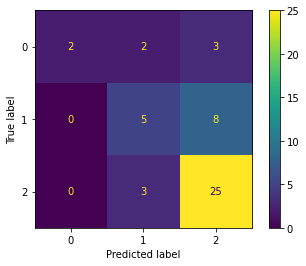

              precision    recall  f1-score   support

           0       0.29      1.00      0.44         2
           1       0.38      0.50      0.43        10
           2       0.89      0.69      0.78        36

    accuracy                           0.67        48
   macro avg       0.52      0.73      0.55        48
weighted avg       0.76      0.67      0.70        48



In [30]:
lr2 = LogisticRegression()
lr2.fit(train_matrix,y_train)
predictions = lr2.predict(test_matrix)
cf_matrix = confusion_matrix(y_test, predictions)
disp = ConfusionMatrixDisplay(cf_matrix)
disp.plot()
plt.show()
print(classification_report(predictions,y_test, labels=[0,1,2]))

In [31]:
train_matrix = np.hstack([train[['word_count','char_count','avg_word_length']].to_numpy(),train_vectorized_2])
test_matrix = np.hstack([test[['word_count','char_count','avg_word_length']].to_numpy(),test_vectorized_2])

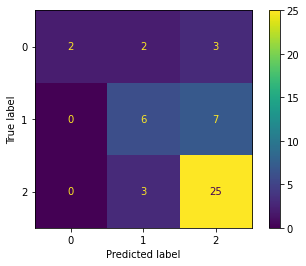

              precision    recall  f1-score   support

           0       0.29      1.00      0.44         2
           1       0.46      0.55      0.50        11
           2       0.89      0.71      0.79        35

    accuracy                           0.69        48
   macro avg       0.55      0.75      0.58        48
weighted avg       0.77      0.69      0.71        48



In [32]:
lr2 = LogisticRegression()
lr2.fit(train_matrix,y_train)
predictions = lr2.predict(test_matrix)
cf_matrix = confusion_matrix(y_test, predictions)
disp = ConfusionMatrixDisplay(cf_matrix)
disp.plot()
plt.show()
print(classification_report(predictions,y_test, labels=[0,1,2]))

In [54]:
from sklearn.pipeline import Pipeline
from sklearn.pipeline import FeatureUnion
from sklearn.model_selection import GridSearchCV

combined_features = FeatureUnion([('tfidf', TfidfVectorizer(ngram_range=(1, 3))),
                                  ('tfidf_char', TfidfVectorizer(ngram_range=(1, 3), analyzer='char'))])
pipeline = Pipeline([("features", combined_features),
                     ('clf', LogisticRegression(class_weight='balanced'))])
parameters = {
    'features__tfidf__max_df': (0.3, 0.75),
    'features__tfidf_char__max_df': (0.3, 0.75),    
    'clf__estimator__C': (1.0, 10.0)
}
grid_search = GridSearchCV(pipeline, parameters, cv=5,
                               n_jobs=-1, verbose=1, scoring='f1_macro')
grid_search.fit(train['Sentence'], train['label'])


Fitting 5 folds for each of 8 candidates, totalling 40 fits


In [33]:
countvectorizer = CountVectorizer(token_pattern=r'\b\w+\b')
train_wordcount = countvectorizer.fit_transform(train['Sentence']).toarray()
test_wordcount = countvectorizer.transform(test['Sentence']).toarray()
train[countvectorizer.get_feature_names_out()+'_cntvec'] = train_wordcount
test[countvectorizer.get_feature_names_out()+'_cntvec'] = test_wordcount
tfidfvectorizer = TfidfVectorizer(token_pattern=r'\b\w+\b')
train_tfidf = tfidfvectorizer.fit_transform(train['Sentence']).toarray()
test_tfidf = tfidfvectorizer.transform(test['Sentence']).toarray()
train[tfidfvectorizer.get_feature_names_out()+'_tfidfvec'] = train_tfidf
test[tfidfvectorizer.get_feature_names_out()+'_tfidfvec'] = test_tfidf
X_train = train.drop(columns=['Sentence', 'label_name', 'label','Positive','Negative','Neutral'])
X_test = test.drop(columns=[ 'Sentence', 'label_name', 'label','Positive','Negative','Neutral'])
y_train = train['label']
y_test = test['label']
lr = LogisticRegression()
lr.fit(X_train,y_train)
predictions = lr.predict(X_test)

In [34]:
shap.initjs()

In [43]:
explainer = shap.explainers.Linear(lr, X_train,output_names=[0,1,2], feature_names=X_train.columns)

# calculate SHAP values
shap_values = explainer.shap_values(X_test)

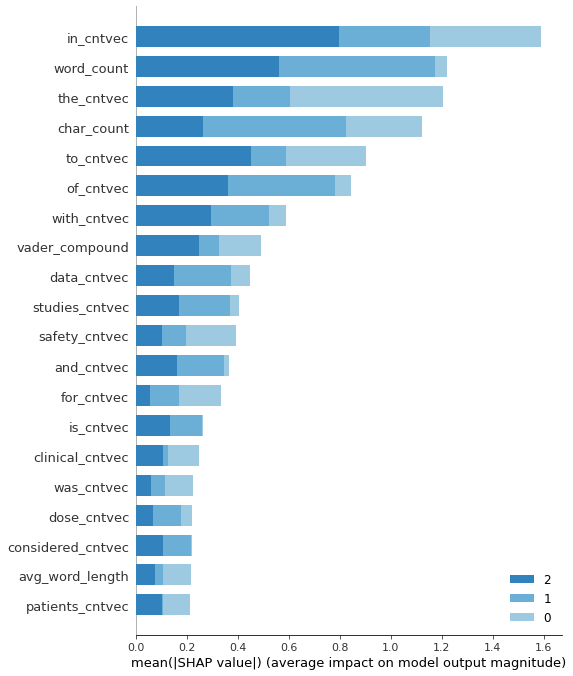

In [44]:
shap.summary_plot(shap_values, X_train, plot_type="bar", class_names= [0,1,2], color=plt.get_cmap("tab20c"))

Force plot for test sample classified as positive


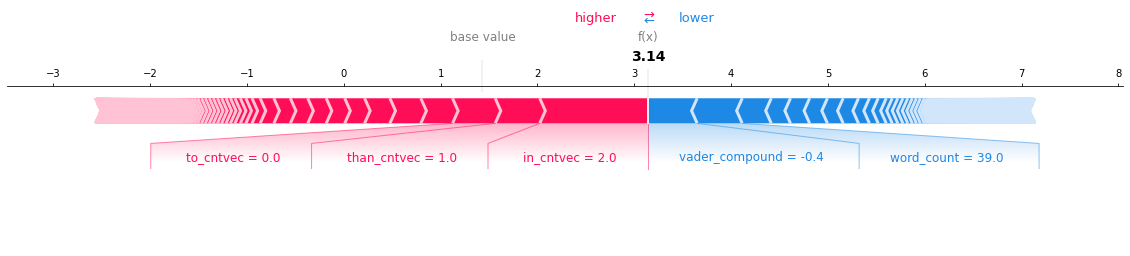

In [51]:
idx = 1
# only explain prediction for top class
c = predictions[1]

print('Force plot for test sample classified as {}'.format('positive'))

shap.force_plot(explainer.expected_value[c], shap_values[c][idx,:], X_test.iloc[idx].round(2), feature_names = X_train.columns, matplotlib=True)

Force plot for test sample negative


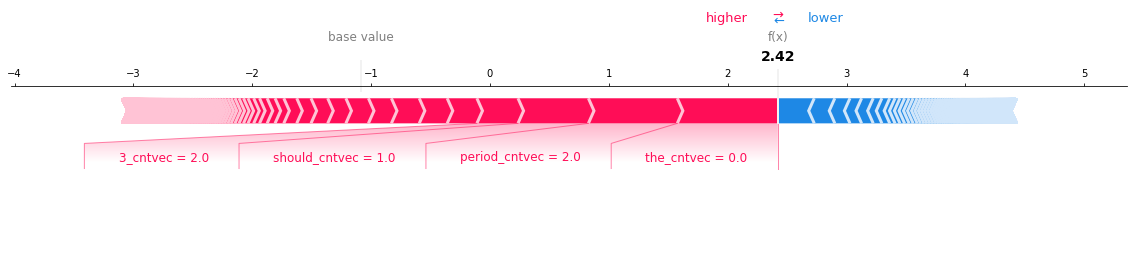

In [52]:
idx = -1
# only explain prediction for top class
c = predictions[-1]

print('Force plot for test sample {}'.format('negative'))

shap.force_plot(explainer.expected_value[c], shap_values[c][idx,:], X_test.iloc[idx].round(2), feature_names = X_train.columns, matplotlib=True)

Force plot for test sample neutral


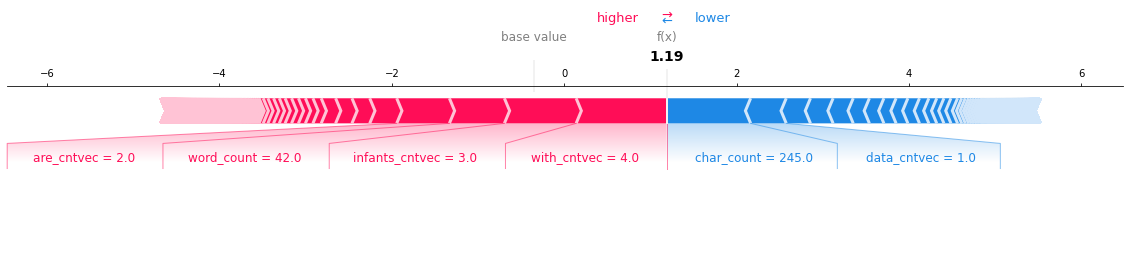

In [53]:
idx = 0
# only explain prediction for top class
c = predictions[idx]

print('Force plot for test sample {}'.format('neutral'))

shap.force_plot(explainer.expected_value[c], shap_values[c][idx,:], X_test.iloc[idx].round(2), feature_names = X_train.columns, matplotlib=True)